In [1]:
# import libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import keras
from tensorflow.keras import layers
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

import datetime

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Bidirectional

[Predicting Sequential Data using LSTM: An Introduction](https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816)

In [2]:
streaming=pd.read_csv('cpu4.csv')
for i in range(len(streaming)):
    streaming['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(streaming['timestamp'].iloc[i]) #We are given the timestamp as a unix code
cols=[i for i in streaming.columns if i not in ['timestamp']]
for col in cols:
    streaming[col]=pd.to_numeric(streaming[col])
streaming['timestamp'] = pd.to_datetime(streaming['timestamp'])
streaming.tail()

,timestamp,value,label
17563,2016-09-23 19:35:00,0.074292,0
17564,2016-09-23 19:40:00,0.295152,0
17565,2016-09-23 19:45:00,0.074292,0
17566,2016-09-23 19:50:00,-0.146567,0
17567,2016-09-23 19:55:00,-0.036137,0


In [3]:
streaming.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17568 entries, 0 to 17567
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  17568 non-null  datetime64[ns]
 1   value      17568 non-null  float64       
 2   label      17568 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 411.9 KB


In [4]:
streaming.head() 

,timestamp,value,label
0,2016-07-24 20:00:00,0.847300,0
1,2016-07-24 20:05:00,-0.036137,0
2,2016-07-24 20:10:00,0.074292,0
3,2016-07-24 20:15:00,0.074292,0
4,2016-07-24 20:20:00,-0.036137,0


In [5]:
streaming.tail()

,timestamp,value,label
17563,2016-09-23 19:35:00,0.074292,0
17564,2016-09-23 19:40:00,0.295152,0
17565,2016-09-23 19:45:00,0.074292,0
17566,2016-09-23 19:50:00,-0.146567,0
17567,2016-09-23 19:55:00,-0.036137,0


In [6]:
cpu4=streaming['value']
timestamp=streaming['timestamp']
label=streaming['label']

Text(0.5, 1.0, 'Streaming Dataset')

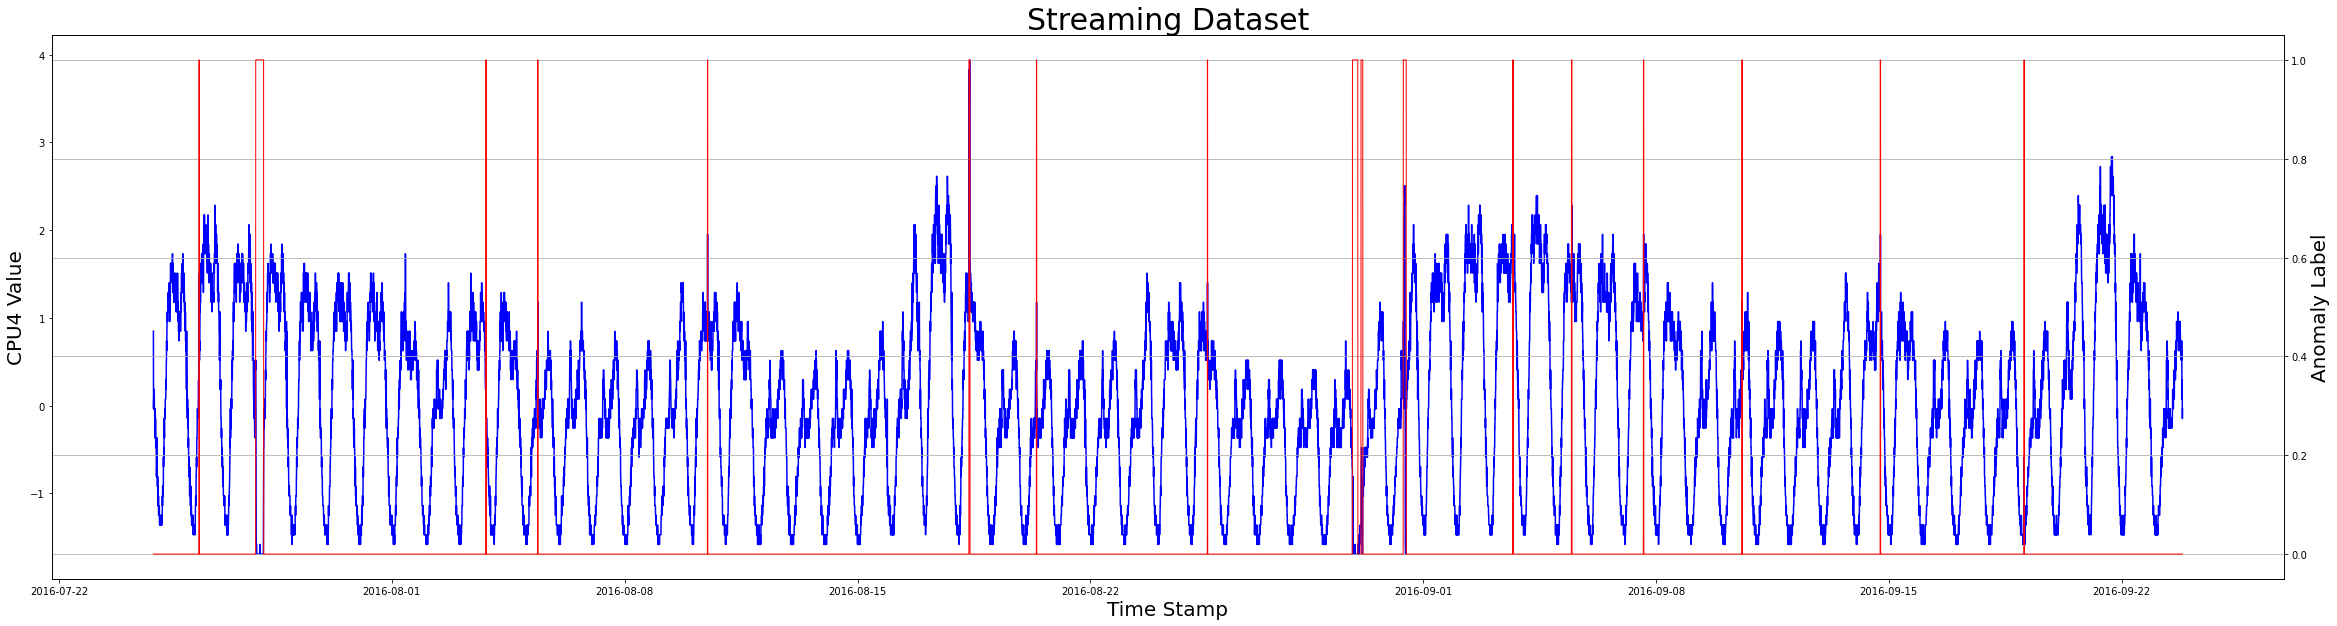

In [7]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(timestamp, cpu4, color='blue')
ax2a.plot(timestamp, label, color='red', linewidth='1')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('CPU4 Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

plt.grid()

plt.title('Streaming Dataset', fontsize=30)

In [8]:
timestamp
arr=np.where(timestamp=='2020-08-24 00:00:00+02:00')
arr

(array([], dtype=int64),)

In [9]:
timestamp
arr=np.where(label==1)
arr

(array([  395,   396,   397,   886,   887,   888,   889,   890,   891,
          892,   893,   894,   895,   896,   897,   898,   899,   900,
          901,   902,   903,   904,   905,   906,   907,   908,   909,
          910,   911,   912,   913,   914,   915,   916,   917,   918,
          919,   920,   921,   922,   923,   924,   925,   926,   927,
          928,   929,   930,   931,   932,   933,   934,   935,   936,
          937,   938,   939,   940,   941,   942,   943,   944,   945,
          946,   947,   948,   949,   950,   951,   952,   953,   954,
         2879,  2880,  2881,  3327,  3328,  3329,  4797,  4798,  4799,
         7061,  7062,  7063,  7064,  7065,  7066,  7067,  7068,  7069,
         7645,  7646,  7647,  9125,  9126,  9127, 10381, 10382, 10383,
        10384, 10385, 10386, 10387, 10388, 10389, 10390, 10391, 10392,
        10393, 10394, 10395, 10396, 10397, 10398, 10399, 10400, 10401,
        10402, 10403, 10404, 10405, 10406, 10407, 10408, 10409, 10410,
      

In [10]:
split1a=timestamp[0]
split1b=timestamp[1000]

split2a=timestamp[2800]
split2b=timestamp[3500]

split3a=timestamp[4600]
split3b=timestamp[5000]

split4a=timestamp[7000]
split4b=timestamp[7700]

split5a=timestamp[9000]
split5b=timestamp[9200]

split6a=timestamp[10200]
split6b=timestamp[11000]

split7a=timestamp[11700]
split7b=timestamp[12350]

split8a=timestamp[12800]
split8b=timestamp[13000]

split9a=timestamp[13690]
split9b=timestamp[13820]

split10a=timestamp[14900]
split10b=timestamp[15000]

split11a=timestamp[16100]
split11b=timestamp[16300]

Start date is:  2016-07-24 20:00:00
End date is:  2016-09-23 19:55:00
Length of full data: 17568


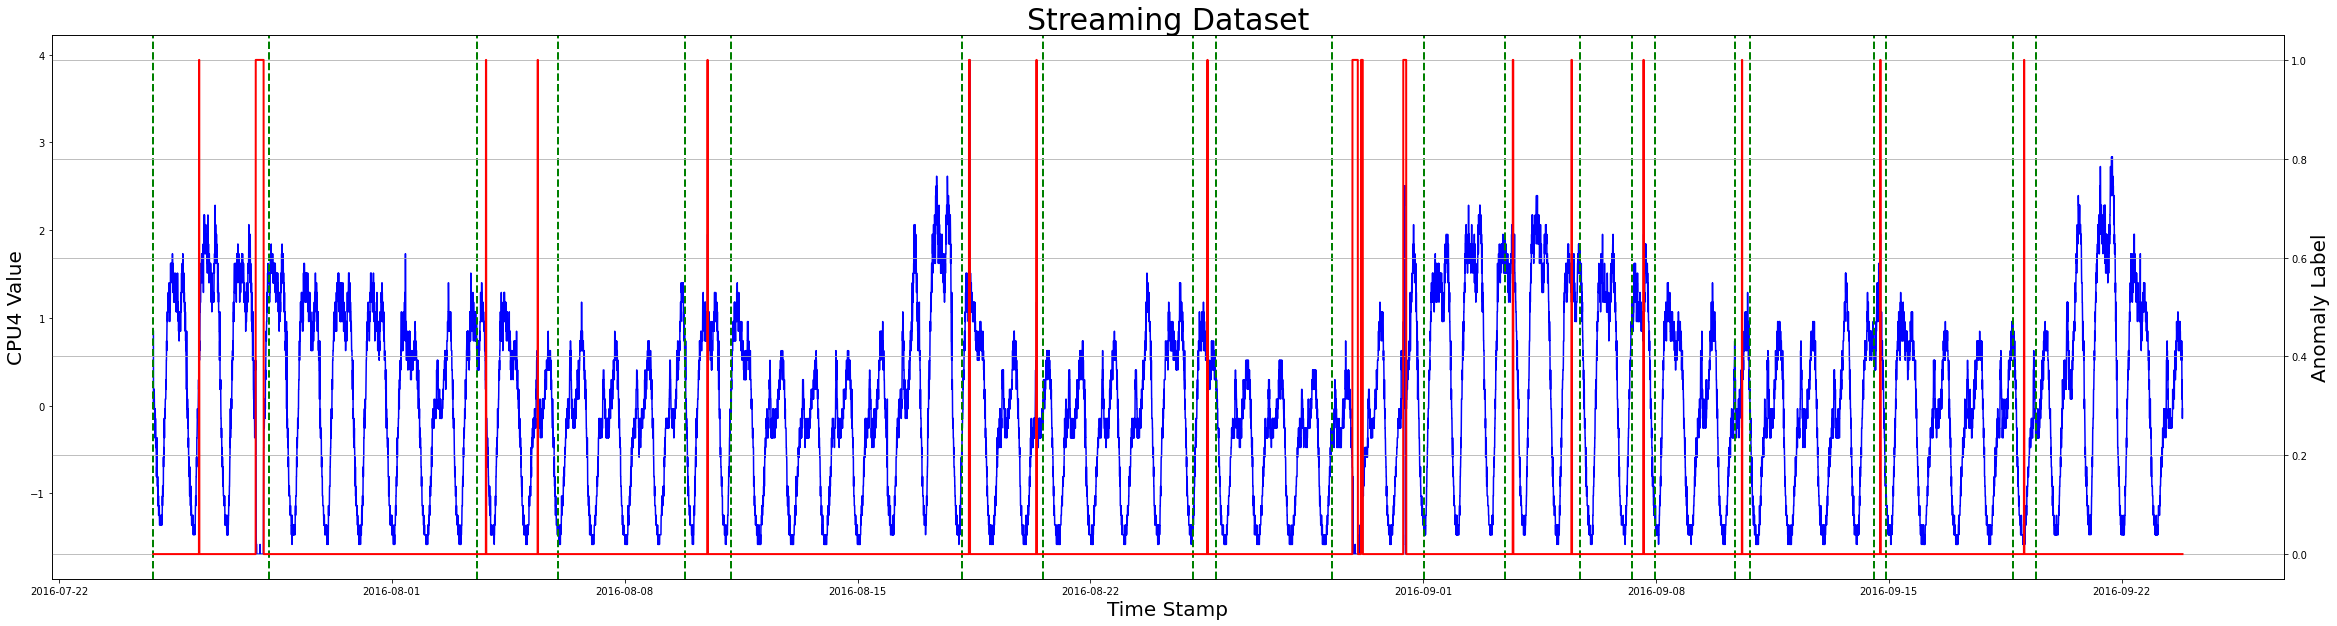

In [11]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(timestamp, cpu4, color='blue')
ax2a.plot(timestamp, label, color='red', linewidth='2')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('CPU4 Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

ax2d.axvline(split1a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split1b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split2a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split2b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split3a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split3b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split4a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split4b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split5a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split5b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split6a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split6b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split7a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split7b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split8a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split8b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split9a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split9b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split10a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split10b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split11a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split11b, color='green', linestyle='dashed', linewidth='2')


plt.grid()

plt.title('Streaming Dataset', fontsize=30)

print("Start date is: ", timestamp.min())
print("End date is: ", timestamp.max())
print(f"Length of full data: {len(streaming)}")

In [12]:
# splits=[split1, split2, split3, split4, split5, split6]
# splits

In [13]:
# Training intervals
train1 = streaming.loc[(timestamp > split1b) & (timestamp < split2a)]
train2 = streaming.loc[(timestamp > split2b) & (timestamp < split3a)]
train3 = streaming.loc[(timestamp > split3b) & (timestamp < split4a)]
train4 = streaming.loc[(timestamp > split4b) & (timestamp < split5a)]
train5 = streaming.loc[(timestamp > split5b) & (timestamp < split6a)]
train6 = streaming.loc[(timestamp > split6b) & (timestamp < split7a)]
train7 = streaming.loc[(timestamp > split7b) & (timestamp < split8a)]
train8 = streaming.loc[(timestamp > split8b) & (timestamp < split9a)]
train9 = streaming.loc[(timestamp > split9b) & (timestamp < split10a)]
train10 = streaming.loc[(timestamp > split10b) & (timestamp < split11a)]
train11 = streaming.loc[timestamp > split11b]


# Testing intervals
test1 = streaming.loc[(timestamp >= split1a) & (timestamp <= split1b)]
test2 = streaming.loc[(timestamp >= split2a) & (timestamp <= split2b)]
test3 = streaming.loc[(timestamp >= split3a) & (timestamp <= split3b)]
test4 = streaming.loc[(timestamp >= split4a) & (timestamp <= split4b)]
test5 = streaming.loc[(timestamp >= split5a) & (timestamp <= split5b)]
test6 = streaming.loc[(timestamp >= split6a) & (timestamp <= split6b)]
test7 = streaming.loc[(timestamp >= split7a) & (timestamp <= split7b)]
test8 = streaming.loc[(timestamp >= split8a) & (timestamp <= split8b)]
test9 = streaming.loc[(timestamp >= split9a) & (timestamp <= split9b)]
test10 = streaming.loc[(timestamp >= split10a) & (timestamp <= split10b)]
test11 = streaming.loc[(timestamp >= split11a) & (timestamp <= split11b)]

Text(0.5, 1.0, 'Streaming Dataset')

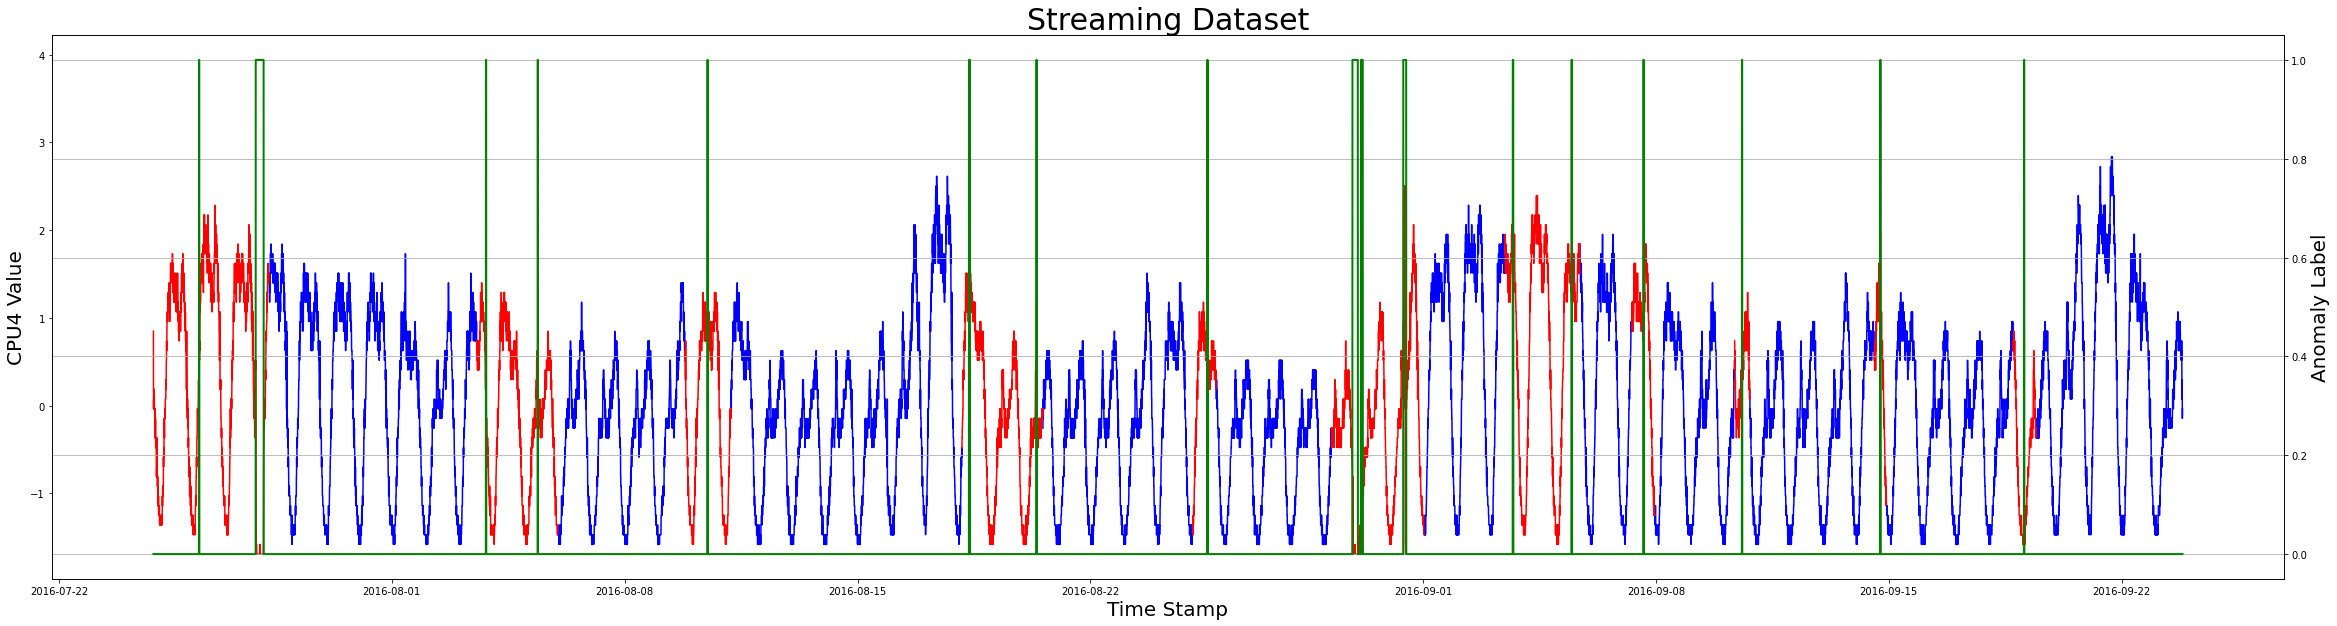

In [14]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(train1['timestamp'], train1['value'], color='blue')
ax2d.plot(test1['timestamp'], test1['value'], color='red')
ax2d.plot(train2['timestamp'], train2['value'], color='blue')
ax2d.plot(test2['timestamp'], test2['value'], color='red')
ax2d.plot(train3['timestamp'], train3['value'], color='blue')
ax2d.plot(test3['timestamp'], test3['value'], color='red')
ax2d.plot(train4['timestamp'], train4['value'], color='blue')
ax2d.plot(test4['timestamp'], test4['value'], color='red')
ax2d.plot(train5['timestamp'], train5['value'], color='blue')
ax2d.plot(test5['timestamp'], test5['value'], color='red')
ax2d.plot(train6['timestamp'], train6['value'], color='blue')
ax2d.plot(test6['timestamp'], test6['value'], color='red')
ax2d.plot(train7['timestamp'], train7['value'], color='blue')
ax2d.plot(test7['timestamp'], test7['value'], color='red')
ax2d.plot(train8['timestamp'], train8['value'], color='blue')
ax2d.plot(test8['timestamp'], test8['value'], color='red')
ax2d.plot(train9['timestamp'], train9['value'], color='blue')
ax2d.plot(test9['timestamp'], test9['value'], color='red')
ax2d.plot(train10['timestamp'], train10['value'], color='blue')
ax2d.plot(test10['timestamp'], test10['value'], color='red')
ax2d.plot(train11['timestamp'], train11['value'], color='blue')
ax2d.plot(test11['timestamp'], test11['value'], color='red')

ax2a.plot(timestamp, label, color='green', linewidth='2')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('CPU4 Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

# ax2d.axvline(split1, color='orange', linestyle='dashed', linewidth='2')
# ax2d.axvline(split2, color='orange', linestyle='dashed', linewidth='2')
# ax2d.axvline(split3, color='orange', linestyle='dashed', linewidth='2')
# ax2d.axvline(split4, color='orange', linestyle='dashed', linewidth='2')
# ax2d.axvline(split5, color='orange', linestyle='dashed', linewidth='2')
# ax2d.axvline(split6, color='orange', linestyle='dashed', linewidth='2')

plt.grid()

plt.title('Streaming Dataset', fontsize=30)

In [15]:
# Preprocessing: normalize the data in mean and variance
scaler = StandardScaler()
scaler = scaler.fit(pd.concat([train1, train2, train3, train4, train5, train6, train7, train8, train9, train10, train11])[['value']]) #To normalize the mean and variance

train1['value'] = scaler.transform(train1['value'].to_numpy().reshape(-1,1))
train2['value'] = scaler.transform(train2['value'].to_numpy().reshape(-1,1))
train3['value'] = scaler.transform(train3['value'].to_numpy().reshape(-1,1))
train4['value'] = scaler.transform(train4['value'].to_numpy().reshape(-1,1))
train5['value'] = scaler.transform(train5['value'].to_numpy().reshape(-1,1))
train6['value'] = scaler.transform(train6['value'].to_numpy().reshape(-1,1))
train7['value'] = scaler.transform(train7['value'].to_numpy().reshape(-1,1))
train8['value'] = scaler.transform(train8['value'].to_numpy().reshape(-1,1))
train9['value'] = scaler.transform(train9['value'].to_numpy().reshape(-1,1))
train10['value'] = scaler.transform(train10['value'].to_numpy().reshape(-1,1))
train11['value'] = scaler.transform(train11['value'].to_numpy().reshape(-1,1))

trainSeqs = [train1, train2, train3, train4, train5, train6, train7, train8, train9, train10, train11]

# Avoid leakage of information between train and test dataset

test1['value'] = scaler.transform(test1['value'].to_numpy().reshape(-1,1))
test2['value'] = scaler.transform(test2['value'].to_numpy().reshape(-1,1))
test3['value'] = scaler.transform(test3['value'].to_numpy().reshape(-1,1))
test4['value'] = scaler.transform(test4['value'].to_numpy().reshape(-1,1))
test5['value'] = scaler.transform(test5['value'].to_numpy().reshape(-1,1))
test6['value'] = scaler.transform(test6['value'].to_numpy().reshape(-1,1))
test7['value'] = scaler.transform(test7['value'].to_numpy().reshape(-1,1))
test8['value'] = scaler.transform(test8['value'].to_numpy().reshape(-1,1))
test9['value'] = scaler.transform(test9['value'].to_numpy().reshape(-1,1))
test10['value'] = scaler.transform(test10['value'].to_numpy().reshape(-1,1))
test11['value'] = scaler.transform(test11['value'].to_numpy().reshape(-1,1))

testSeqs = [test1, test2, test3, test4, test5, test6, test7, test8, test9, test10, test11]

In [16]:
# Compute the train to test ratio

learn_ratio = pd.concat(trainSeqs).shape[0] / streaming.shape[0]
print("Training dataset percentage: " "{:.2f}" "%".format(learn_ratio*100))

test_ratio = pd.concat(testSeqs).shape[0] / streaming.shape[0]
print("Testing dataset percentage: " "{:.2f}" "%".format(test_ratio*100))

Training dataset percentage: 71.02%
Testing dataset percentage: 28.98%


In [17]:
trainSeqs

[               timestamp     value  label
 1001 2016-07-28 07:25:00  1.500612      0
 1002 2016-07-28 07:30:00  1.613902      0
 1003 2016-07-28 07:35:00  1.500612      0
 1004 2016-07-28 07:40:00  1.387321      0
 1005 2016-07-28 07:45:00  1.387321      0
 ...                  ...       ...    ...
 2795 2016-08-03 12:55:00  1.047451      0
 2796 2016-08-03 13:00:00  0.934161      0
 2797 2016-08-03 13:05:00  1.047451      0
 2798 2016-08-03 13:10:00  0.934161      0
 2799 2016-08-03 13:15:00  0.707580      0
 
 [1799 rows x 3 columns],
                timestamp     value  label
 3501 2016-08-05 23:45:00 -1.444934      0
 3502 2016-08-05 23:50:00 -1.331643      0
 3503 2016-08-05 23:55:00 -1.444934      0
 3504 2016-08-06 00:00:00 -1.444934      0
 3505 2016-08-06 00:05:00 -1.444934      0
 ...                  ...       ...    ...
 4595 2016-08-09 18:55:00  0.934161      0
 4596 2016-08-09 19:00:00  1.047451      0
 4597 2016-08-09 19:05:00  0.820870      0
 4598 2016-08-09 19:10:00 

In [18]:
testSeqs

[               timestamp     value  label
 0    2016-07-24 20:00:00  0.934161      0
 1    2016-07-24 20:05:00  0.027839      0
 2    2016-07-24 20:10:00  0.141129      0
 3    2016-07-24 20:15:00  0.141129      0
 4    2016-07-24 20:20:00  0.027839      0
 ...                  ...       ...    ...
 996  2016-07-28 07:00:00  1.613902      0
 997  2016-07-28 07:05:00  1.500612      0
 998  2016-07-28 07:10:00  1.613902      0
 999  2016-07-28 07:15:00  1.613902      0
 1000 2016-07-28 07:20:00  1.613902      0
 
 [1001 rows x 3 columns],
                timestamp     value  label
 2800 2016-08-03 13:20:00  0.707580      0
 2801 2016-08-03 13:25:00  0.820870      0
 2802 2016-08-03 13:30:00  0.594290      0
 2803 2016-08-03 13:35:00  0.707580      0
 2804 2016-08-03 13:40:00  0.707580      0
 ...                  ...       ...    ...
 3496 2016-08-05 23:20:00 -1.331643      0
 3497 2016-08-05 23:25:00 -1.444934      0
 3498 2016-08-05 23:30:00 -1.444934      0
 3499 2016-08-05 23:35:00 

In [19]:
TIME_STEPS = 26 #Could change the timesteps default=32
sample_predict=1

# Create the sequences of size TIME_STEPS to feed the sequential model
def to_sequences(x, y, TIME_STEPS=1):
    x_values = []
    y_values = []

    for i in range(len(x)-TIME_STEPS):
        x_values.append(x.iloc[i:(i+TIME_STEPS)].values)
        y_values.append(y.iloc[i+sample_predict:(i+TIME_STEPS+sample_predict)].values)
        
    return np.array(x_values), np.array(y_values)

# Stack the sequences obtained in each period to create a single training tensor
trainX = np.array([])
trainY = np.array([])
testX = np.array([])
testY = np.array([])

for train in trainSeqs:
    x, y = to_sequences(train[['value']], train[['value']], TIME_STEPS)
    trainX = np.vstack([trainX, x]) if trainX.size else x
    trainY = np.vstack([trainY, y]) if trainY.size else y
    
for test in testSeqs:
    x, y = to_sequences(test[['value']], test[['value']], TIME_STEPS)
    testX = np.vstack([testX, x]) if testX.size else x
    testY = np.vstack([testY, y]) if testY.size else y

In [20]:
print(f"Train X shape: {trainX.shape[0]} batches, {trainX.shape[1]} values for each batch, {trainX.shape[2]} dimensional batch")
print(f"Train Y shape: {trainY.shape[0]} batches, {trainY.shape[1]} values for each batch, {trainY.shape[2]} dimensional batch")
print(f"Test X shape: {testX.shape[0]} batches, {testX.shape[1]} values for each batch, {testX.shape[2]} dimensional batch")
print(f"Test Y shape: {testY.shape[0]} batches, {testY.shape[1]} values for each batch, {testY.shape[2]} dimensional batch")
# 15951 + 3984 + (32*7) = 20159
# 32 values for each sample
# 3984 testing batches

Train X shape: 12191 batches, 26 values for each batch, 1 dimensional batch
Train Y shape: 12191 batches, 26 values for each batch, 1 dimensional batch
Test X shape: 4805 batches, 26 values for each batch, 1 dimensional batch
Test Y shape: 4805 batches, 26 values for each batch, 1 dimensional batch


In [21]:
# print(trainX[0])
# print("")
# print(trainX[1])

In [22]:
# print(trainX[0])
# print("")
# print(trainY[0])

# Creating the Neural Network

In [23]:
model = Sequential()
model.add(layers.LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(layers.Dropout(rate=0.2))

model.add(layers.RepeatVector(trainX.shape[1]))

model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(rate=0.2))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(optimizer='adam', loss='mae')
model.summary()

2022-09-27 11:53:38.744039: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 26, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 26, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 26, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 26, 1)            129       
 ibuted)                                                

In [24]:
# Fit model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])

Epoch 1/50
343/343 [==============================] - 20s 54ms/step - loss: 0.1596 - val_loss: 0.1156
Epoch 2/50
343/343 [==============================] - 26s 75ms/step - loss: 0.1086 - val_loss: 0.1264
Epoch 3/50
343/343 [==============================] - 33s 97ms/step - loss: 0.1039 - val_loss: 0.1071
Epoch 4/50
343/343 [==============================] - 28s 81ms/step - loss: 0.1003 - val_loss: 0.0978
Epoch 5/50
343/343 [==============================] - 31s 91ms/step - loss: 0.0980 - val_loss: 0.0982
Epoch 6/50
343/343 [==============================] - 32s 92ms/step - loss: 0.0970 - val_loss: 0.0939
Epoch 7/50
343/343 [==============================] - 31s 91ms/step - loss: 0.0965 - val_loss: 0.1257
Epoch 8/50
343/343 [==============================] - 33s 97ms/step - loss: 0.0935 - val_loss: 0.0989
Epoch 9/50
343/343 [==============================] - 33s 95ms/step - loss: 0.0928 - val_loss: 0.0955
Epoch 10/50
343/343 [==============================] - 31s 91ms/step - loss: 0.092

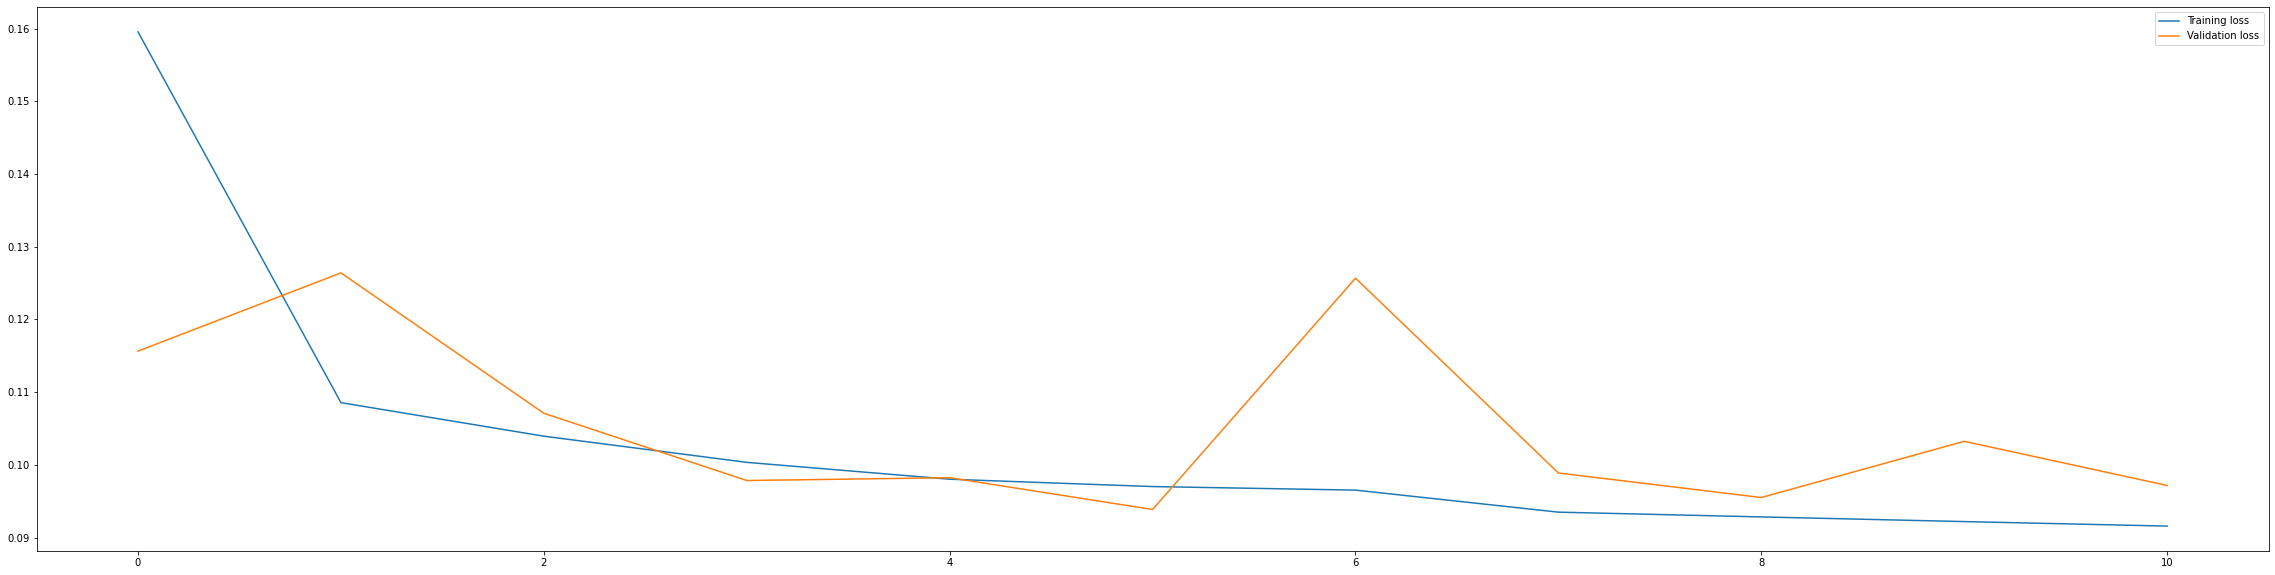

In [25]:
# Plot the training and validation loss 
plt.figure(figsize=(40,10))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Train Predict Shape (12191, 26, 1)
Train Y Shape (12191, 26, 1)


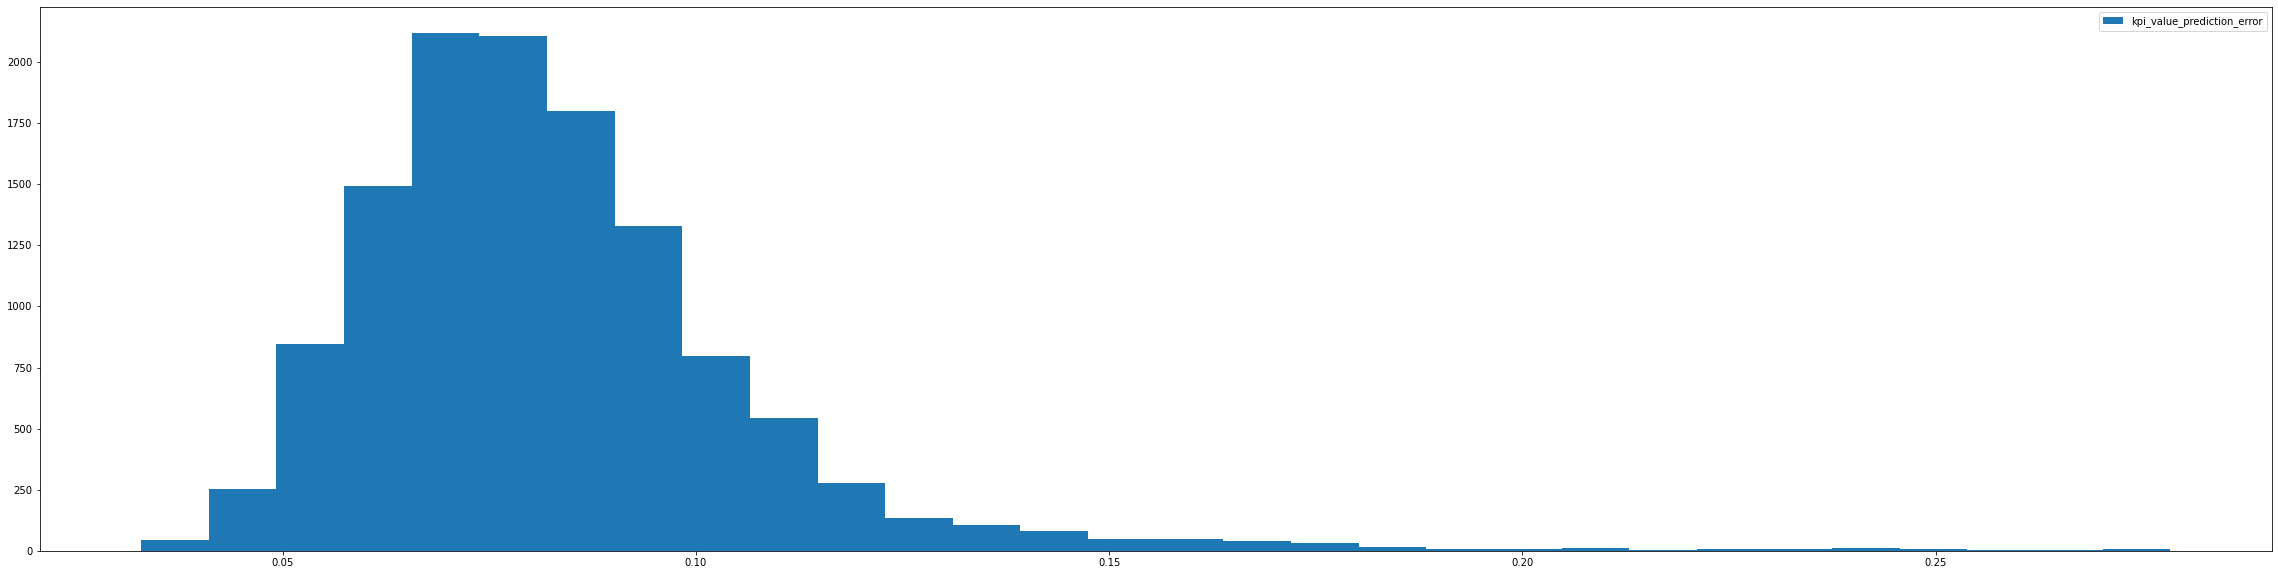

In [26]:
# Plot a histogram of the reconstruction error in the training dataset to decide a threshold

trainPredict = model.predict(trainX)
print(f"Train Predict Shape {trainPredict.shape}")
print(f"Train Y Shape {trainY.shape}")
trainMAE = np.mean(np.abs(trainPredict - trainY), axis=1)
plt.figure(figsize=(40,10));
plt.hist(trainMAE, bins=30);
plt.legend(['kpi_value_prediction_error'])
threshold_trainMAE = 0.30  #or Define 90% value of max as threshold.

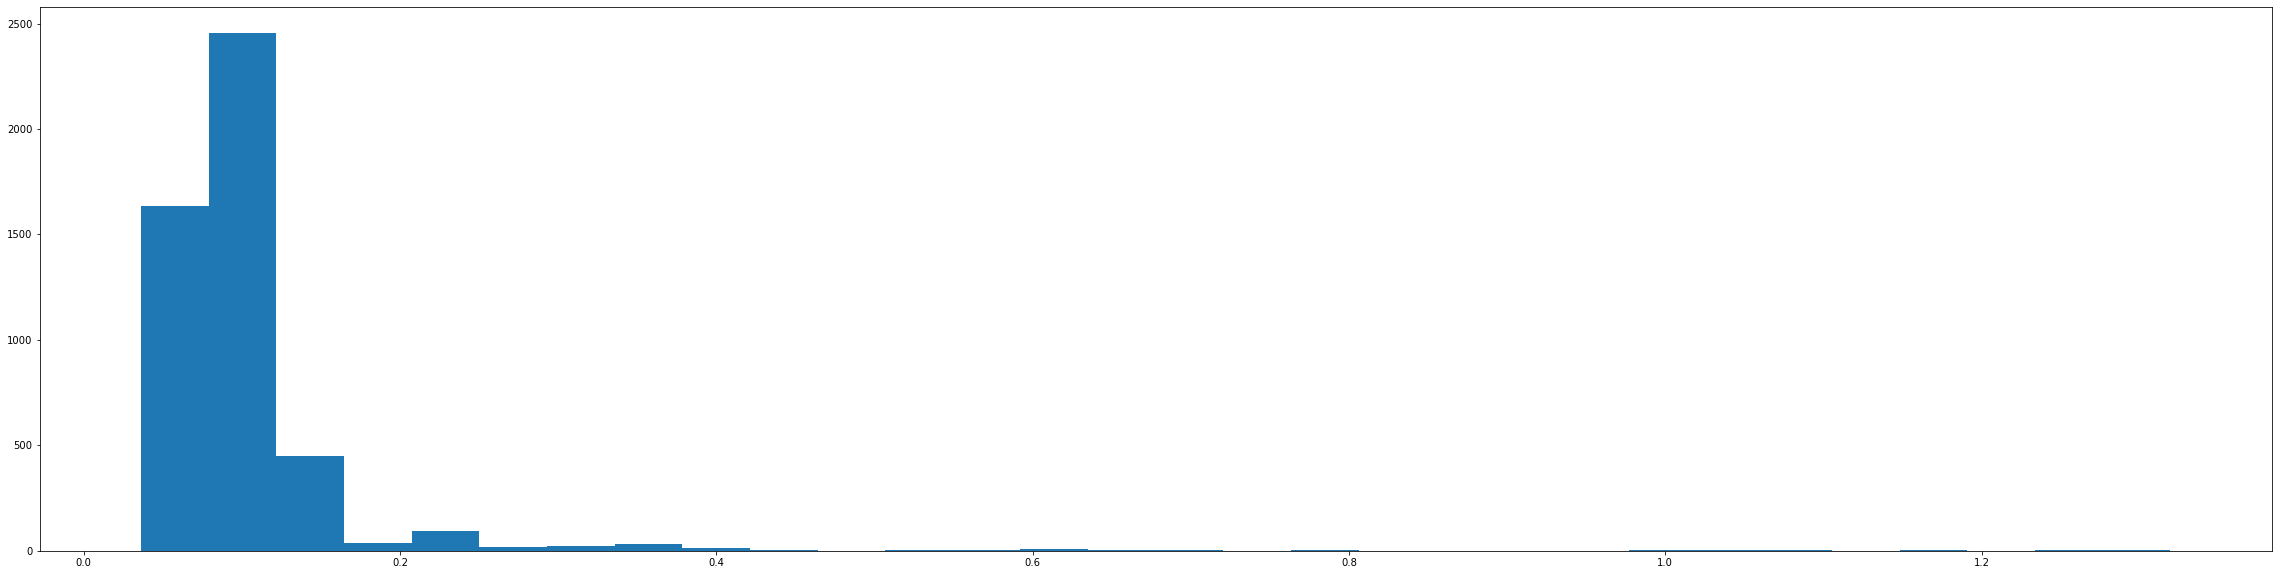

In [27]:
# Histogram of the testing MAE
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testY), axis=1)
plt.figure(figsize=(40,10));
plt.hist(testMAE, bins=30);

In [28]:
# Detect anomaly if the reconstruction loss for a sample is greater than the threshold

anomaly_df = pd.concat([seq[TIME_STEPS:] for seq in testSeqs])
anomaly_df['testMAE'] = testMAE
anomaly_df['threshold_trainMAE'] = threshold_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['threshold_trainMAE']

In [29]:
# plt.figure(figsize=(40,10))
# for i in range(trainPredict.shape[0]):
#     plt.plot(trainPredict[i])

In [30]:
# plt.figure(figsize=(40,10))
# for i in range(testPredict.shape[0]):
#     plt.plot(testPredict[i])

In [31]:
testPredict.shape[0]

4805

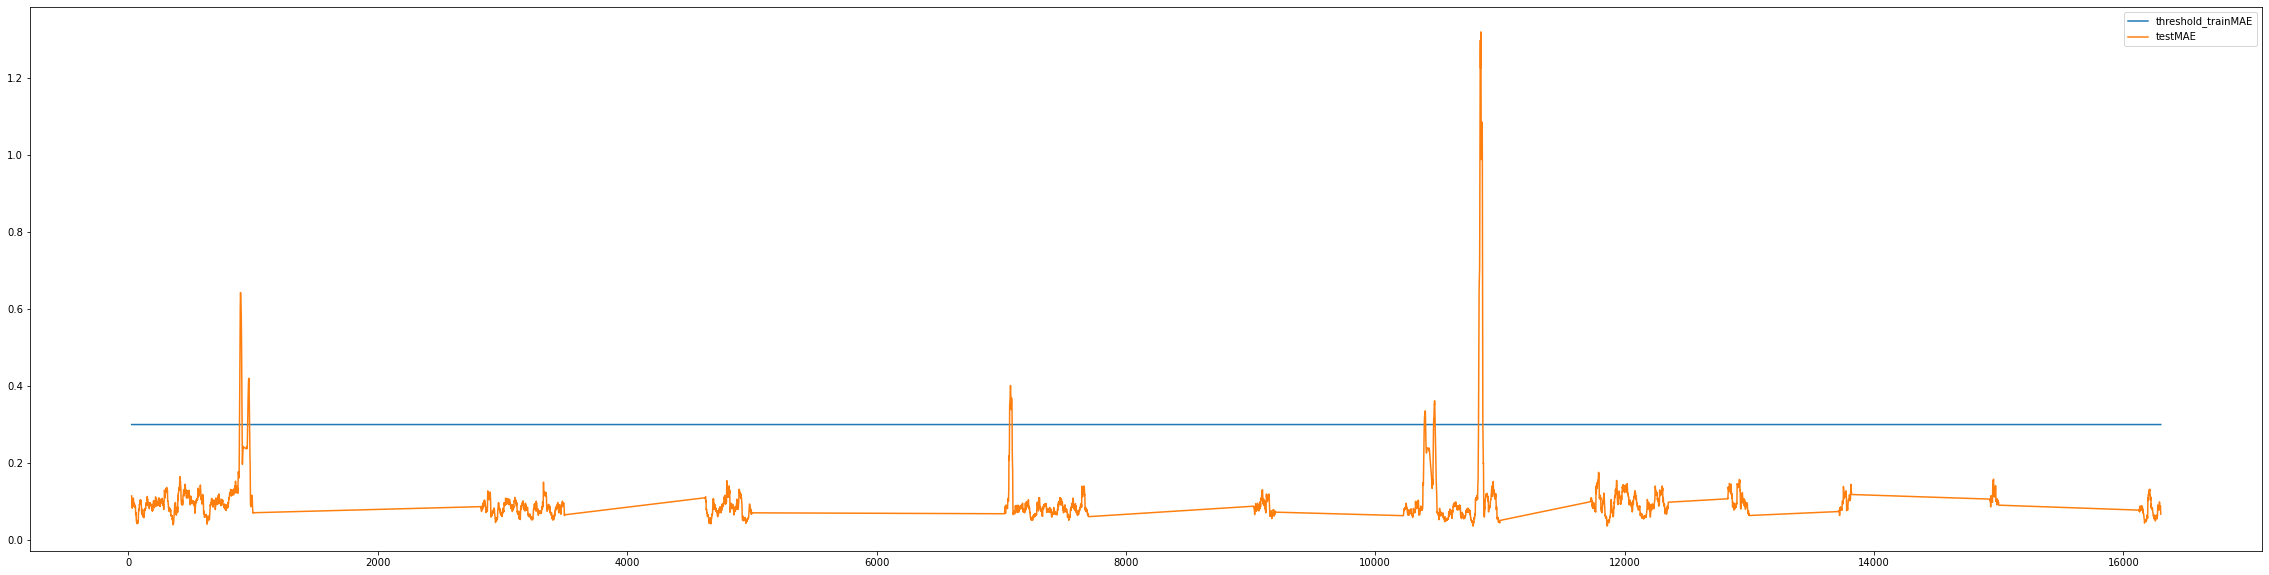

In [32]:
# Plot the test MAE
plt.figure(figsize=[40, 10])
anomaly_df['threshold_trainMAE'].plot()
anomaly_df['testMAE'].plot()
plt.legend()

In [33]:
# Detect the anomaly points inside the dataset
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

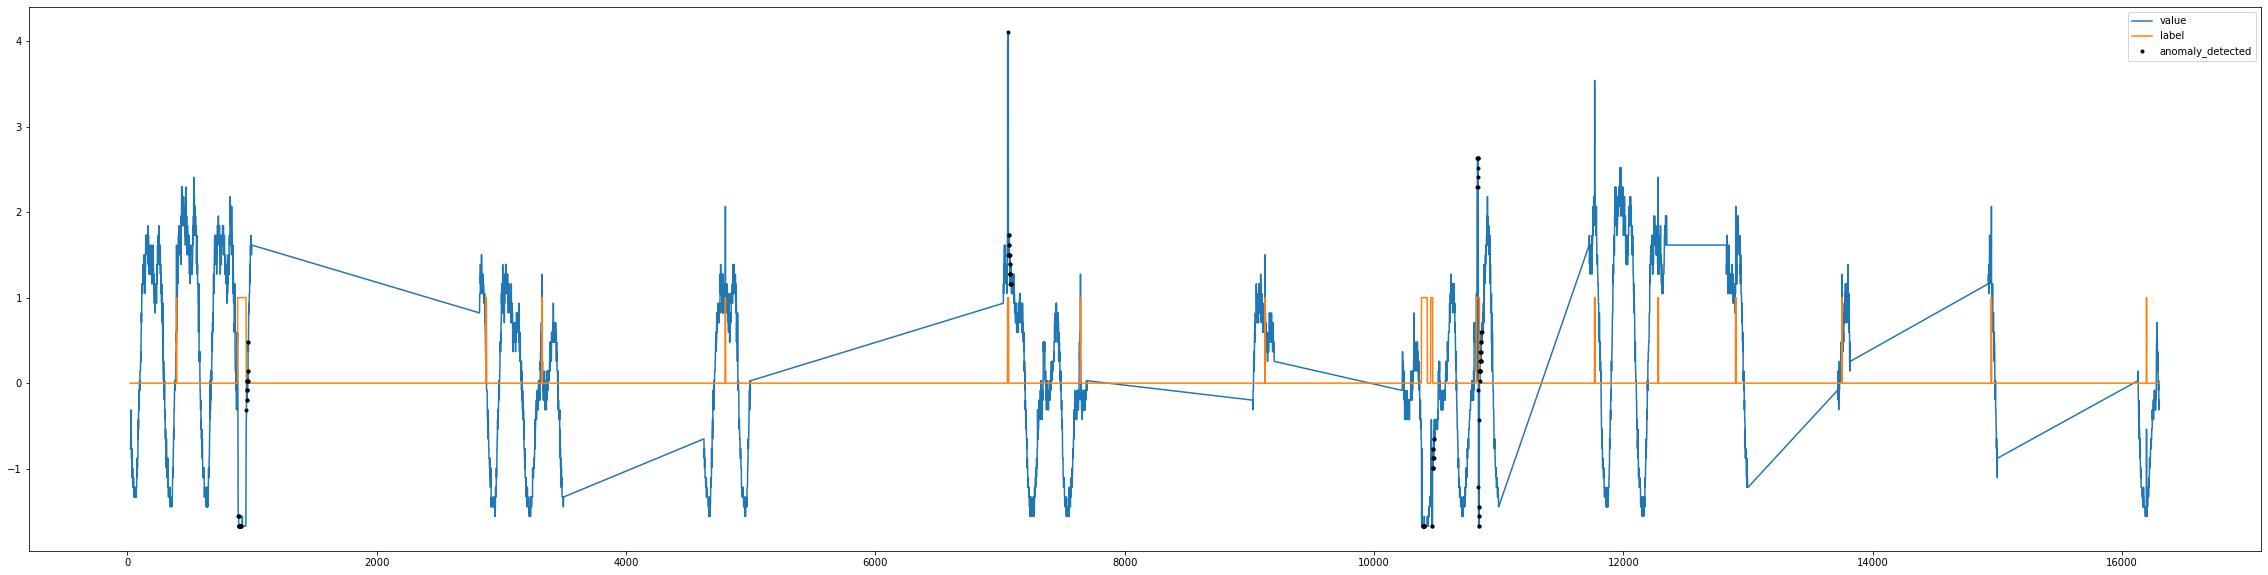

In [34]:
#Plot the anomalies
plt.figure(figsize=(40,10))
anomaly_df['value'].plot()
anomaly_df['label'].plot()
anomalies['value'].plot(marker='.', linestyle='None', label='anomaly_detected', color='black')
plt.legend()

In [35]:
# Inspect the resulting dataset
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4805 entries, 26 to 16300
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           4805 non-null   datetime64[ns]
 1   value               4805 non-null   float64       
 2   label               4805 non-null   int64         
 3   testMAE             4805 non-null   float64       
 4   threshold_trainMAE  4805 non-null   float64       
 5   anomaly             4805 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 229.9 KB


In [36]:
anomaly_df

,timestamp,value,label,testMAE,threshold_trainMAE,anomaly
26,2016-07-24 22:10:00,-0.765192,0,0.114745,0.3,False
27,2016-07-24 22:15:00,-0.765192,0,0.099177,0.3,False
28,2016-07-24 22:20:00,-0.651902,0,0.096720,0.3,False
29,2016-07-24 22:25:00,-0.651902,0,0.094357,0.3,False
30,2016-07-24 22:30:00,-0.765192,0,0.090376,0.3,False
...,...,...,...,...,...,...
16296,2016-09-19 10:00:00,-0.312032,0,0.085771,0.3,False
16297,2016-09-19 10:05:00,-0.198741,0,0.089383,0.3,False
16298,2016-09-19 10:10:00,-0.198741,0,0.087163,0.3,False
16299,2016-09-19 10:15:00,-0.198741,0,0.079799,0.3,False


In [37]:
# Compute the precision in the test dataset
precision=precision_score(anomaly_df['label'], anomaly_df['anomaly'])
print(f"Precision: {round(precision, 3)}")
# Compute the recall in the test dataset
recall=recall_score(anomaly_df['label'], anomaly_df['anomaly'])
print(f"Recall: {round(recall, 3)}")
# Compute the F1 score in the test dataset
f1_score=f1_score(anomaly_df['label'], anomaly_df['anomaly'])
print(f"F1 Score: {round(f1_score, 3)}")

Precision: 0.474
Recall: 0.258
F1 Score: 0.334
